Libraries

In [1]:
import pandas as pd
import shapely.wkt
import gc
import geopandas as gpd
import json
from shapely.geometry import Point
from matplotlib import pyplot as plt

from mlmodels.od_radius import get_buffers
from bikescience.grid import Grid

base_folder = '../../data/boston/training-sets/processing/'
flow_id = ['i_start', 'j_start', 'i_end', 'j_end']

Input data

In [2]:
flows = pd.read_csv(base_folder + 'general-flows.csv')
flows.origin = flows.origin.apply(shapely.wkt.loads)
flows.destination = flows.destination.apply(shapely.wkt.loads)
origin_radius = get_buffers(flows, 'origin')
dest_radius = get_buffers(flows, 'destination')
del flows
gc.collect()

14

In [3]:
def load_mbta(file):
    with open(file) as f:
        mbta_data = json.load(f)
    geodf_data = {'name': [], 'geometry': []}
    for pt in mbta_data:
        geodf_data['name'].append(pt['name'])
        geodf_data['geometry'].append(Point(pt['longitude'], pt['latitude']))
    return gpd.GeoDataFrame(geodf_data)

mbta_folder = '../../data/boston/mbta-stops/'
subway_stops = load_mbta(mbta_folder + 'boston-stops-subway.json')
rail_ferry_stops = load_mbta(mbta_folder + 'boston-stops-rail-ferry.json')
bus_stops = load_mbta(mbta_folder + 'boston-stops-bus.json')

Origin

In [4]:
subway_total = gpd.sjoin(subway_stops, origin_radius, op='within') \
                  .groupby(flow_id, as_index=False) \
                  .agg({'name': 'count'})
subway_total.rename(columns={'name': 'subway_count'}, inplace=True)
subway_total.head()

/usr/local/lib/python3.5/dist-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


i_start  j_start  i_end  j_end  subway_count
0        0       13      0     11             1
1        0       13      0     13             1
2        0       13      1     10             1
3        0       13      2     10             1
4        0       13      2     11             1

In [5]:
subway_total.subway_count.value_counts()

1    4181
2    1944
3     408
4     303
6      85
8      25
5      13
Name: subway_count, dtype: int64

In [6]:
bus_total = gpd.sjoin(bus_stops, origin_radius, op='within') \
                  .groupby(['i_start', 'j_start', 'i_end', 'j_end'], as_index=False) \
                  .agg({'name': 'count'})
bus_total.rename(columns={'name': 'bus_count'}, inplace=True)
bus_total.head()

i_start  j_start  i_end  j_end  bus_count
0        0       11      0     11          6
1        0       11      0     13          6
2        0       11      1     10          6
3        0       11      2      9          6
4        0       11      2     10          6

In [7]:
bus_total.bus_count.value_counts()

9     1490
12    1477
15    1313
8     1111
11    1006
6      909
13     839
7      720
14     699
10     691
16     678
5      604
18     556
2      539
20     539
17     437
4      431
3      364
21     278
19     274
22     234
1      185
24     167
33     166
25     164
26     154
23     147
29     112
28      64
36      39
30      34
37      28
42      25
39      18
47      14
35      14
43      14
32      13
31      13
34      13
38      12
41      11
40      11
53       9
44       9
56       5
45       4
54       4
46       3
58       2
52       2
27       2
55       2
51       1
48       1
57       1
Name: bus_count, dtype: int64

In [8]:
rail_ferry_total = gpd.sjoin(rail_ferry_stops, origin_radius, op='within') \
                  .groupby(['i_start', 'j_start', 'i_end', 'j_end'], as_index=False) \
                  .agg({'name': 'count'})
rail_ferry_total.rename(columns={'name': 'rail_ferry_count'}, inplace=True)
rail_ferry_total.head()

i_start  j_start  i_end  j_end  rail_ferry_count
0        3       12      0     11                 1
1        3       12      0     13                 1
2        3       12      1     10                 1
3        3       12      2      6                 1
4        3       12      2      7                 1

In [9]:
rail_ferry_total.rail_ferry_count.value_counts()

1    847
4    367
3    302
8    116
2     70
9     30
Name: rail_ferry_count, dtype: int64

In [10]:
grid = Grid().geodataframe()
grid['fake_id'] = 42
all_vs_all = grid.merge(grid, on='fake_id', suffixes=('_start', '_end'))[flow_id]
origin = all_vs_all.merge(subway_total, on=flow_id, how='outer') \
                   .merge(rail_ferry_total, on=flow_id, how='outer') \
                   .merge(bus_total, on=flow_id, how='outer') \
                   .fillna(0)
print(len(origin), len(all_vs_all), len(subway_total), len(bus_total), len(rail_ferry_total))
origin.head()

160000 160000 6959 16652 1732


i_start  j_start  i_end  j_end  subway_count  rail_ferry_count  bus_count
0        0        0      0      0           0.0               0.0        0.0
1        0        0      0      1           0.0               0.0        0.0
2        0        0      0      2           0.0               0.0        0.0
3        0        0      0      3           0.0               0.0        0.0
4        0        0      0      4           0.0               0.0        0.0

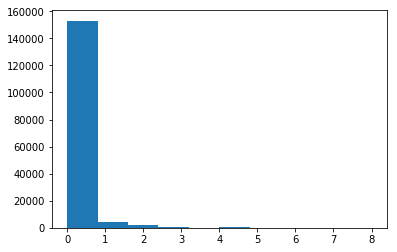

In [11]:
plt.hist(origin.subway_count)
plt.show()

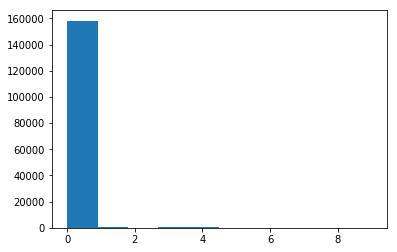

In [12]:
plt.hist(origin.rail_ferry_count)
plt.show()

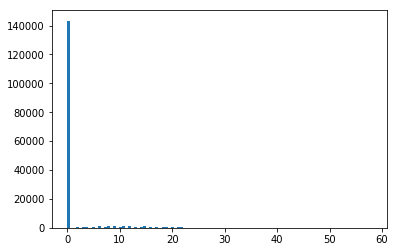

In [13]:
plt.hist(origin.bus_count, bins=100)
plt.show()

Destination

In [14]:
subway_total = gpd.sjoin(subway_stops, dest_radius, op='within') \
                  .groupby(flow_id, as_index=False) \
                  .agg({'name': 'count'})
subway_total.rename(columns={'name': 'subway_count'}, inplace=True)
subway_total.head()

i_start  j_start  i_end  j_end  subway_count
0        0       11      0     13             1
1        0       11      2     14             1
2        0       11      4     14             1
3        0       11      6      6             1
4        0       11      7     10             1

In [15]:
subway_total.subway_count.value_counts()

1    4216
2    1920
3     419
4     299
6      94
5      19
8      14
Name: subway_count, dtype: int64

In [16]:
bus_total = gpd.sjoin(bus_stops, dest_radius, op='within') \
                  .groupby(['i_start', 'j_start', 'i_end', 'j_end'], as_index=False) \
                  .agg({'name': 'count'})
bus_total.rename(columns={'name': 'bus_count'}, inplace=True)
bus_total.head()

i_start  j_start  i_end  j_end  bus_count
0        0       11      0     11          6
1        0       11      0     13         18
2        0       11      1     10         20
3        0       11      2      9         11
4        0       11      2     10         23

In [17]:
bus_total.bus_count.value_counts()

12    1497
9     1428
15    1260
8     1117
11    1019
6      965
13     829
10     734
7      722
16     722
14     649
5      598
18     590
20     558
2      530
4      441
17     401
3      359
21     283
19     260
22     230
1      197
25     170
24     164
26     157
33     143
23     141
29     111
28      55
36      35
42      29
30      28
43      24
37      24
34      22
47      22
35      20
39      19
32      14
27      13
41      11
38      11
44      10
31       9
40       8
56       5
46       5
55       3
51       3
54       3
52       2
45       2
53       1
Name: bus_count, dtype: int64

In [18]:
rail_ferry_total = gpd.sjoin(rail_ferry_stops, dest_radius, op='within') \
                  .groupby(['i_start', 'j_start', 'i_end', 'j_end'], as_index=False) \
                  .agg({'name': 'count'})
rail_ferry_total.rename(columns={'name': 'rail_ferry_count'}, inplace=True)
rail_ferry_total.head()

i_start  j_start  i_end  j_end  rail_ferry_count
0        0       11      3     12                 1
1        0       11      4     14                 3
2        0       11      5     12                 1
3        0       11      9     11                 4
4        0       13      4     14                 3

In [19]:
rail_ferry_total.rail_ferry_count.value_counts()

1    830
4    366
3    315
8    111
2     68
9     29
Name: rail_ferry_count, dtype: int64

In [20]:
dest = all_vs_all.merge(subway_total, on=flow_id, how='outer') \
                 .merge(rail_ferry_total, on=flow_id, how='outer') \
                 .merge(bus_total, on=flow_id, how='outer') \
                 .fillna(0)
print(len(dest), len(all_vs_all), len(subway_total), len(bus_total), len(rail_ferry_total))
dest.head()

160000 160000 6981 16653 1719


i_start  j_start  i_end  j_end  subway_count  rail_ferry_count  bus_count
0        0        0      0      0           0.0               0.0        0.0
1        0        0      0      1           0.0               0.0        0.0
2        0        0      0      2           0.0               0.0        0.0
3        0        0      0      3           0.0               0.0        0.0
4        0        0      0      4           0.0               0.0        0.0

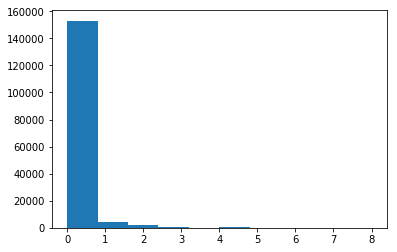

In [21]:
plt.hist(dest.subway_count)
plt.show()

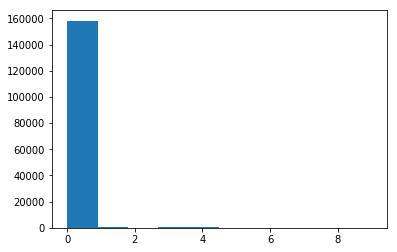

In [22]:
plt.hist(dest.rail_ferry_count)
plt.show()

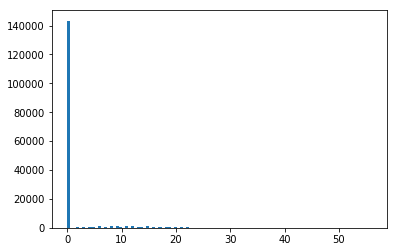

In [23]:
plt.hist(dest.bus_count, bins=100)
plt.show()

Joining all and saving

In [24]:
merge = origin.merge(dest, on=flow_id, suffixes=('_origin', '_dest'))
print(len(merge))
merge.head()

160000


i_start  j_start  i_end  j_end  subway_count_origin  \
0        0        0      0      0                  0.0   
1        0        0      0      1                  0.0   
2        0        0      0      2                  0.0   
3        0        0      0      3                  0.0   
4        0        0      0      4                  0.0   

   rail_ferry_count_origin  bus_count_origin  subway_count_dest  \
0                      0.0               0.0                0.0   
1                      0.0               0.0                0.0   
2                      0.0               0.0                0.0   
3                      0.0               0.0                0.0   
4                      0.0               0.0                0.0   

   rail_ferry_count_dest  bus_count_dest  
0                    0.0             0.0  
1                    0.0             0.0  
2                    0.0             0.0  
3                    0.0             0.0  
4                    0.0             0.0

In [25]:
merge.to_csv(base_folder + 'mbta-stops.csv', index=False)